# An introduction to `relatio` 
**Runtime $\sim$ 5min**

Original paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient, attribute) structure. 

Here, we present the main wrapper functions to quickly obtain narrative statements from a corpus.

----------------------------

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [1]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

/home/germain/Desktop/relatio/.tox/dev/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")
df.head()

,id,doc
0,9.845497e+16,Republicans and Democrats have both created ou...
1,1.234653e+18,I was thrilled to be back in the Great city of...
2,1.304875e+18,The Unsolicited Mail In Ballot Scam is a major...
3,1.223641e+18,Getting a little exercise this morning!
4,1.215248e+18,Thank you Elise!


In [3]:
from relatio import Preprocessor

import spacy
nlp = spacy.load('en_core_web_md')
stop_words = list(nlp.Defaults.stop_words)

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = stop_words,
    n_process = -1,
    batch_size = 100
)

df = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

Splitting into sentences...


100%|███████████████████████████████████| 32323/32323 [00:28<00:00, 1146.81it/s]


In [4]:
from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(df['sentence'][0:100], progress_bar=True)

Running SRL...


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


In [5]:
from relatio import load_data
srl_res = load_data('trump_tweet_archive', 'srl_res')

In [6]:
from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    progress_bar = True
)

for d in roles[0:5]: print(d)

Extracting semantic roles...


100%|██████████████████████████████████| 68616/68616 [00:01<00:00, 40538.98it/s]

{'B-V': 'have'}
{'ARG0': 'Republicans and Democrats', 'ARG1': 'our economic problems', 'B-V': 'created'}
{'ARG1': 'I', 'ARG2': 'thrilled to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'was'}
{'ARG1': 'I', 'ARG2': 'to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'thrilled'}
{'ARG1': 'I', 'ARG2': 'back in the Great city of Charlotte , North Carolina', 'B-V': 'be'}


In [7]:
postproc_roles = p.process_roles(roles, 
                                 dict_of_pos_tags_to_keep = {
                                     "ARG0": ['PRON', 'NOUN', 'PROPN'],
                                     "B-V": ['VERB'],
                                     "ARG1": ['NOUN', 'PROPN', 'PRON']
                                 }, 
                                 max_length = 50,
                                 progress_bar = True,
                                 output_path = 'postproc_roles.json')

for d in postproc_roles[0:5]: print(d)

Cleaning phrases for role ARG0...


100%|███████████████████████████████████| 49281/49281 [00:20<00:00, 2408.46it/s]


Cleaning phrases for role B-V...


100%|█████████████████████████████████| 135562/135562 [00:50<00:00, 2660.35it/s]


Cleaning phrases for role B-ARGM-MOD...


100%|███████████████████████████████████| 13752/13752 [00:05<00:00, 2484.33it/s]


Cleaning phrases for role ARG1...


100%|███████████████████████████████████| 88730/88730 [00:38<00:00, 2282.26it/s]


Cleaning phrases for role ARG2...


100%|███████████████████████████████████| 32132/32132 [00:15<00:00, 2127.07it/s]


{}
{'ARG0': 'republicans democrats', 'B-V': 'create', 'ARG1': 'problem'}
{}
{'B-V': 'thrill'}
{'ARG2': 'great city charlotte north carolina'}


In [8]:
from relatio.utils import load_roles
postproc_roles = load_roles('postproc_roles.json')

In [9]:
known_entities = p.mine_entities(
    df['sentence'], 
    clean_entities = True, 
    progress_bar = True,
    output_path = 'entities.pkl'
)

for n in known_entities.most_common(10): print(n)

Mining named entities...


100%|███████████████████████████████████| 63339/63339 [00:35<00:00, 1806.33it/s]

('democrats', 1142)
('obama', 973)
('china', 926)
('u s', 839)
('america', 601)
('american', 550)
('trump', 549)
('barackobama', 540)
('republicans', 496)
('', 490)


In [10]:
from relatio.utils import load_entities
known_entities = load_entities('entities.pkl')

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [11]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    clustering = 'kmeans',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1', 'ARG2'],
    roles_with_known_entities = ['ARG0','ARG1','ARG2'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1','ARG2'],
    threshold = 0.3
)    
             
m.fit(postproc_roles, progress_bar = True) # pca_args, umap_args, and cluster_args give compete control to the user

2022-10-12 11:46:49.327320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 11:46:49.357236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 11:46:49.357425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 11:46:49.358512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Matching known entities (with character matching)...


100%|████████████████████████████████████| 7952/7952 [00:00<00:00, 15533.71it/s]


Matching known entities (with character matching)...


100%|██████████████████████████████████| 25162/25162 [00:01<00:00, 14645.99it/s]


Matching known entities (with character matching)...


100%|██████████████████████████████████| 15228/15228 [00:01<00:00, 14529.33it/s]


Computing phrase embeddings...


  0%|                                                 | 0/30050 [00:00<?, ?it/s]2022-10-12 11:46:59.226389: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-12 11:46:59.226411: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-12 11:46:59.226423: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, lea

Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
Clustering parameters chosen in this range:
{'n_clusters': [29, 74, 149, 224, 300], 'random_state': 0}
Labeling the clusters by the most frequent phrases...


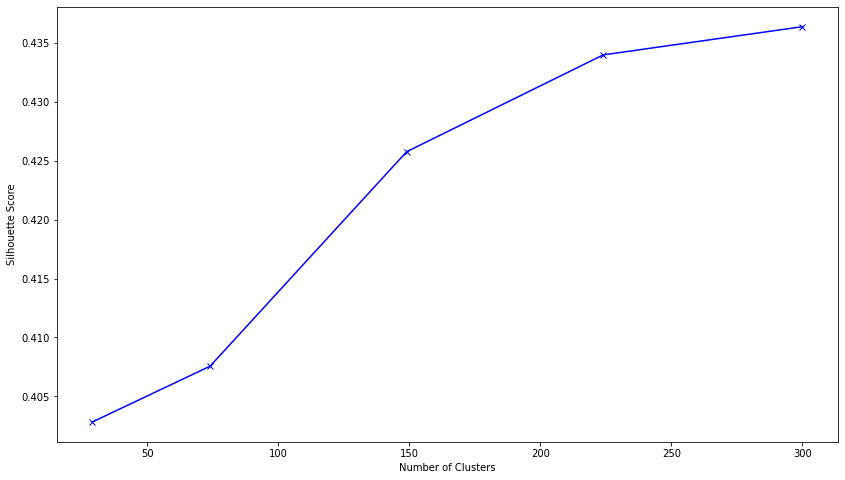

In [13]:
if m.clustering == 'kmeans':
    m.plot_selection_metric() # only for kmeans 

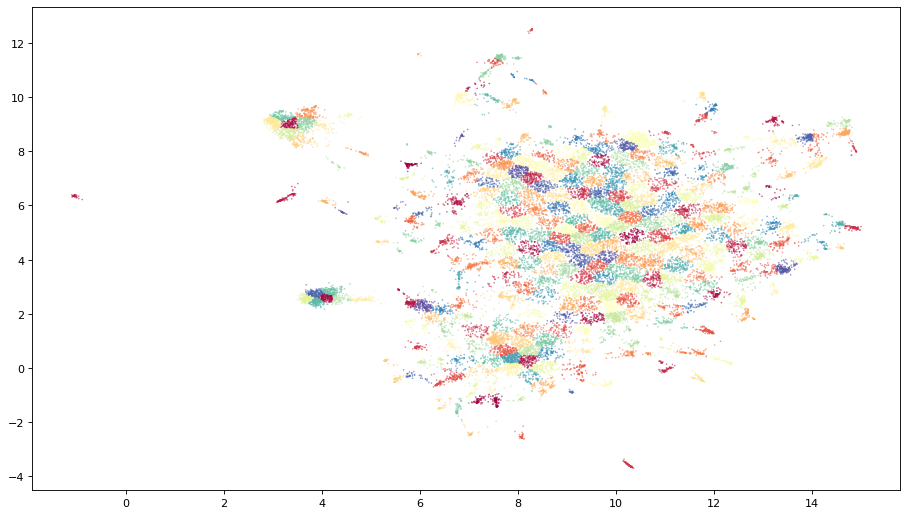

In [14]:
if m.umap_args['n_components'] == 2:
    m.plot_clusters('clusters.pdf') # only for UMAP with 2 components (the default)

In [15]:
m.labels_unknown_entities

{0: 'corruption',
 1: 'place',
 2: 'senator',
 3: 'constitution',
 4: 'barbarajwalter',
 5: 'harvard',
 6: 'important',
 7: 'fire',
 8: 'man amp woman',
 9: 'strong borders crime',
 10: 'government',
 11: 'chris wallace',
 12: 'politic',
 13: 'campaign',
 14: 'president',
 15: 'impeachment',
 16: 'dollar',
 17: 'taxis',
 18: 'lie',
 19: 'star',
 20: 'story',
 21: 'ebola',
 22: 'reporter',
 23: 'witness',
 24: 'tax cut',
 25: 'omarosa',
 26: 'hurricane',
 27: 'arena',
 28: 'interview',
 29: 'proud',
 30: 'signature',
 31: 'bernie sanders',
 32: 'deal',
 33: 'death',
 34: 'chance',
 35: 'meeting',
 36: 'trade',
 37: 'dummy',
 38: 'clue',
 39: 'workforce',
 40: 'governor',
 41: 'daca',
 42: 'refugee',
 43: 'tiger',
 44: 'gun',
 45: 'leader',
 46: 'magazine',
 47: 'jon stewart',
 48: 'debt',
 49: 'germany',
 50: 'prosecutor',
 51: 'james comey',
 52: 'negative',
 53: 'fund',
 54: 'race',
 55: 'tea party',
 56: 'whistleblower',
 57: 'democracy',
 58: 'ambassador',
 59: 'msnbc',
 60: 'kim jo

In [16]:
m.inspect_cluster(label = 'radical left')

[('radical left', 45),
 ('radical', 8),
 ('radical islamic terrorism', 6),
 ('radical islam', 4),
 ('radical left congresswomen', 4),
 ('war radical islamic terrorists', 3),
 ('funding radical ideology', 2),
 ('radical islamic terrorists', 2),
 ('radical left crazy', 2),
 ('radical left crime cancel culture', 2)]

In [17]:
m.clusters_to_txt()

In [18]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 24368/24368 [00:01<00:00, 17006.96it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|████████████████████████████████████| 24368/24368 [01:19<00:00, 307.22it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61012/61012 [00:03<00:00, 15856.94it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61012/61012 [04:01<00:00, 252.65it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG2...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26776/26776 [00:01<00:00, 16361.51it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26776/26776 [01:37<00:00, 274.74it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...


In [19]:
from relatio.utils import prettify
from collections import Counter

pretty_narratives = []
for n in narratives: 
    if n.get('ARG0') is not None:
        if n.get('B-V') is not None:
            if n.get('ARG1') is not None:
                pretty_narratives.append(prettify(n))
                
pretty_narratives = Counter(pretty_narratives)
for t in pretty_narratives.most_common(10): print(t)

('stock market hit record', 9)
('john love military', 8)
('price kill country', 8)
('china want deal', 8)
('democrats want open borders', 7)
('china steal job', 7)
('stock market hit time', 7)
('democrats steal election', 6)
('interview discuss mittromney', 6)
('success breed success', 6)


In [20]:
from relatio import build_graph, draw_graph

G = build_graph(
    narratives, 
    top_n = 100, 
    prune_network = True
)

draw_graph(
    G,
    notebook = False,
    show_buttons = False,
    width="1600px",
    height="1000px",
    output_filename = 'network_of_narratives.html'
    )